In [1]:
pip install mesa

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.5/226.5 kB 4.8 MB/s eta 0:00:00


In [2]:
pip install -U mesa[rec]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.9/107.9 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.4/263.4 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 443.8/443.8 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 45.6 MB/s eta 0:00:00


Running Grid-Based Topology Simulation...


<ipython-input-3-727695888b2c>:41: DeprecationWarning: The time module and all its Schedulers are deprecated and will be removed in Mesa 3.1. They can be replaced with AgentSet functionality. See the migration guide for details. https://mesa.readthedocs.io/latest/migration_guide.html#time-and-schedulers
  self.schedule = RandomActivation(self)


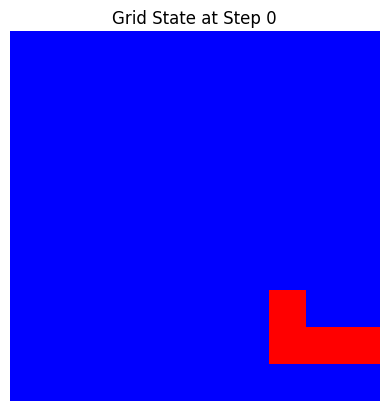

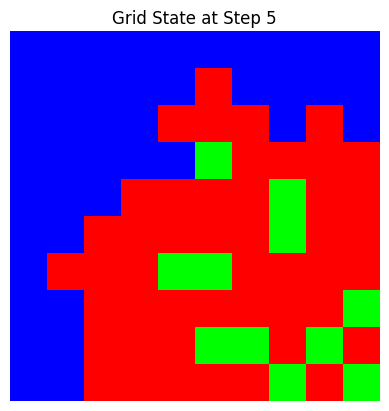

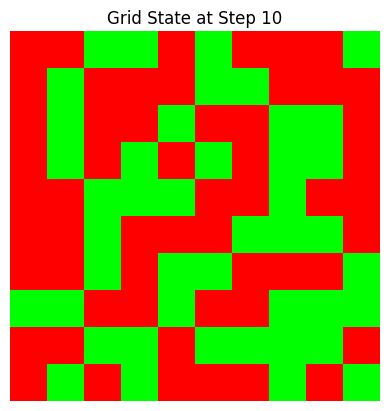

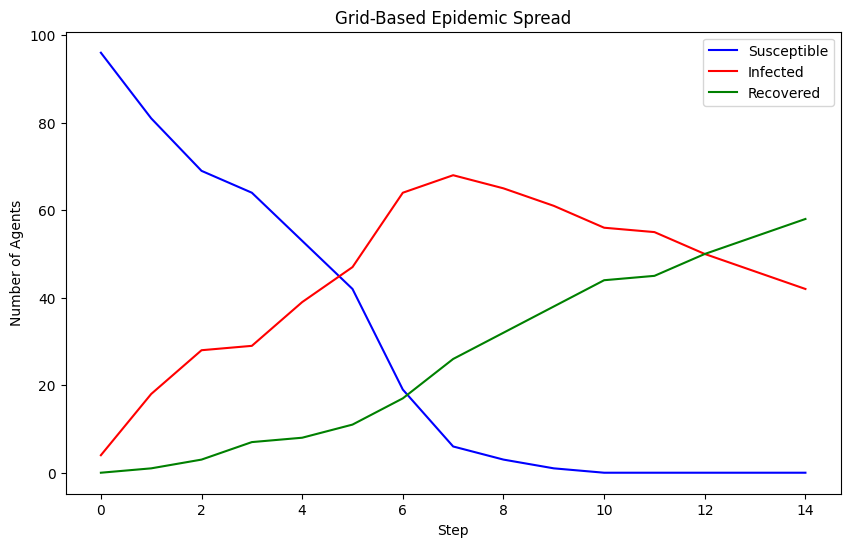

In [3]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np


# Define the Person agent
class Person(Agent):
    def __init__(self, model, state="Susceptible"):
        super().__init__(model)
        self.state = state  # Possible states: "Susceptible", "Infected", "Recovered"

    def step(self):
        if self.state == "Infected":
            # Recover with a certain probability
            if self.model.random.random() < self.model.recovery_prob:
                self.state = "Recovered"
            else:
                # Infect neighbors (depends on topology)
                neighbors = self.model.get_neighbors(self)
                for neighbor in neighbors:
                    if neighbor.state == "Susceptible":
                        if self.model.random.random() < self.model.infection_prob:
                            neighbor.state = "Infected"


# Define the EpidemicModel
class EpidemicModel(Model):
    def __init__(self, num_agents, width, height, topology="grid", infection_prob=0.2, recovery_prob=0.1, seed=100):
        super().__init__(seed=seed)
        self.num_agents = num_agents
        self.infection_prob = infection_prob
        self.recovery_prob = recovery_prob
        self.topology = topology

        if topology == "grid":
            self.grid = MultiGrid(width, height, torus=False)
            self.schedule = RandomActivation(self)
            self.create_grid_agents()
        elif topology == "network":
            self.network = nx.erdos_renyi_graph(num_agents, p=0.1, seed=seed)
            self.schedule = RandomActivation(self)
            self.create_network_agents()

        # Infect one random agent initially
        initial_infected = self.random.choice(self.schedule.agents)
        initial_infected.state = "Infected"

        # Data Collection
        self.datacollector = DataCollector(
            {"Susceptible": lambda m: self.count_agents("Susceptible"),
             "Infected": lambda m: self.count_agents("Infected"),
             "Recovered": lambda m: self.count_agents("Recovered")}
        )

    def create_grid_agents(self):
        for x in range(self.grid.width):
            for y in range(self.grid.height):
                if len(self.schedule.agents) < self.num_agents:
                    person = Person(self)
                    self.grid.place_agent(person, (x, y))
                    self.schedule.add(person)

    def create_network_agents(self):
        for i in range(self.num_agents):
            person = Person(self)
            self.schedule.add(person)

    def get_neighbors(self, agent):
        if self.topology == "grid":
            return [a for a in self.grid.get_neighbors(agent.pos, moore=True, include_center=False)
                    if isinstance(a, Person)]
        elif self.topology == "network":
            node = list(self.schedule.agents).index(agent)
            neighbors = list(self.network.neighbors(node))
            return [list(self.schedule.agents)[n] for n in neighbors]

    def count_agents(self, state):
        return sum(1 for agent in self.schedule.agents if agent.state == state)

    def step(self):
        self.schedule.step()
        self.datacollector.collect(self)


# Visualization for Grid Topology
def visualize_grid(model, step):
    width, height = model.grid.width, model.grid.height
    grid = np.zeros((width, height, 3))  # RGB color grid

    for x in range(width):
        for y in range(height):
            cell = model.grid.get_cell_list_contents((x, y))
            if cell:
                person = cell[0]
                if person.state == "Susceptible":
                    grid[x, y] = [0, 0, 1]  # Blue for Susceptible
                elif person.state == "Infected":
                    grid[x, y] = [1, 0, 0]  # Red for Infected
                elif person.state == "Recovered":
                    grid[x, y] = [0, 1, 0]  # Green for Recovered

    plt.imshow(grid, origin="lower")
    plt.title(f"Grid State at Step {step}")
    plt.axis("off")
    plt.show()


# Visualization for Epidemic Spread
def plot_epidemic_data(model, title="Epidemic Spread"):
    data = model.datacollector.get_model_vars_dataframe()
    plt.figure(figsize=(10, 6))
    plt.plot(data["Susceptible"], label="Susceptible", color="blue")
    plt.plot(data["Infected"], label="Infected", color="red")
    plt.plot(data["Recovered"], label="Recovered", color="green")
    plt.xlabel("Step")
    plt.ylabel("Number of Agents")
    plt.title(title)
    plt.legend()
    plt.show()



def visualize_network(model, step):
    """
    Visualize the network topology with agent states as node colors.
    """
    plt.figure(figsize=(8, 8))
    pos = nx.spring_layout(model.network, seed=42)  # Use a spring layout for aesthetics

    # Map agent states to colors
    color_map = []
    for agent in model.schedule.agents:
        if agent.state == "Susceptible":
            color_map.append("blue")  # Susceptible: Blue
        elif agent.state == "Infected":
            color_map.append("red")  # Infected: Red
        elif agent.state == "Recovered":
            color_map.append("green")  # Recovered: Green

    # Draw the network
    nx.draw(
        model.network,
        pos,
        node_color=color_map,
        with_labels=False,
        node_size=100,
        edge_color="gray"
    )
    plt.title(f"Network State at Step {step}")
    plt.show()


# Run Simulation with Grid Visualization
if __name__ == "__main__":
    # Grid-based topology simulation
    print("Running Grid-Based Topology Simulation...")
    grid_model = EpidemicModel(num_agents=100, width=10, height=10, topology="grid", infection_prob=0.3, recovery_prob=0.1)

    for step in range(15):
        grid_model.step()
        if step % 5 == 0:  # Visualize grid every 5 steps
            visualize_grid(grid_model, step)

    plot_epidemic_data(grid_model, title="Grid-Based Epidemic Spread")


Running Grid-Based Topology Simulation...

Visualizing Grid-Based Topology:


<ipython-input-3-727695888b2c>:41: DeprecationWarning: The time module and all its Schedulers are deprecated and will be removed in Mesa 3.1. They can be replaced with AgentSet functionality. See the migration guide for details. https://mesa.readthedocs.io/latest/migration_guide.html#time-and-schedulers
  self.schedule = RandomActivation(self)


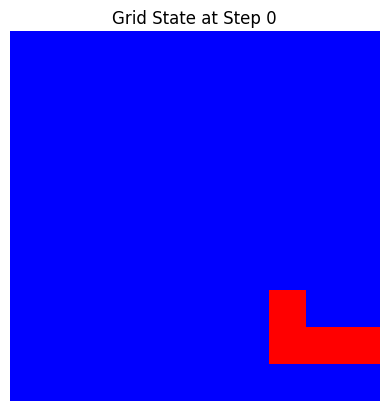

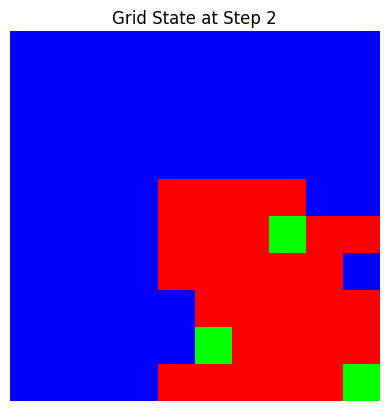

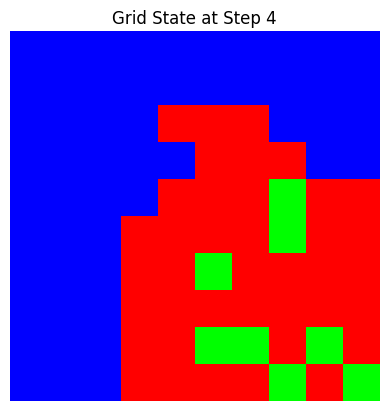

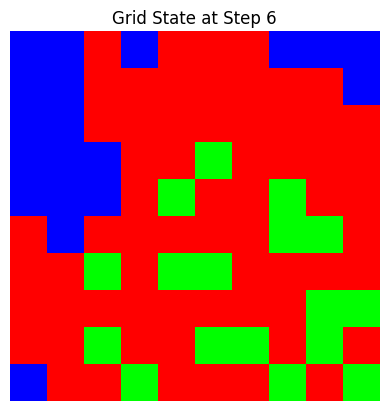

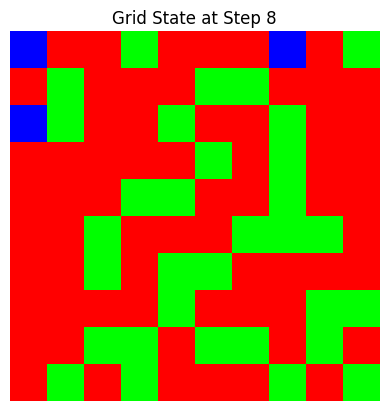

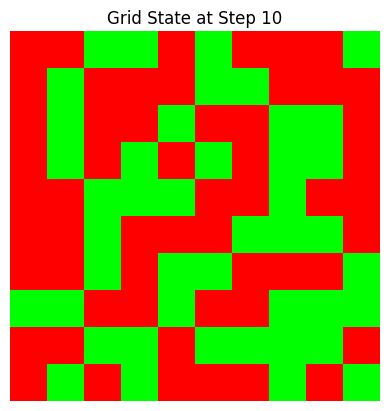

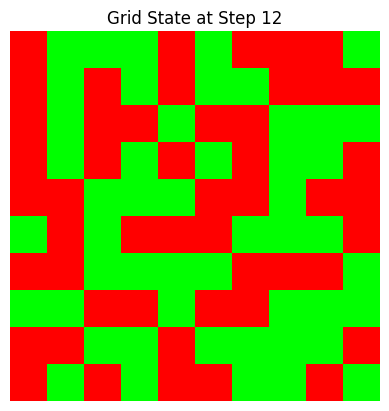

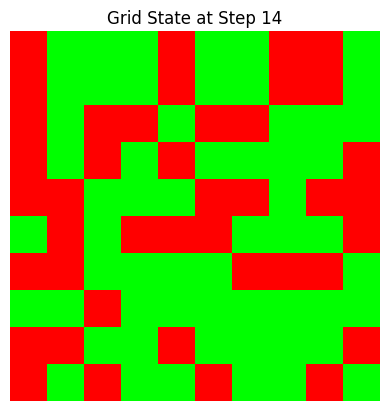


Running Network-Based Topology Simulation...

Visualizing Network-Based Topology:


<ipython-input-3-727695888b2c>:45: DeprecationWarning: The time module and all its Schedulers are deprecated and will be removed in Mesa 3.1. They can be replaced with AgentSet functionality. See the migration guide for details. https://mesa.readthedocs.io/latest/migration_guide.html#time-and-schedulers
  self.schedule = RandomActivation(self)


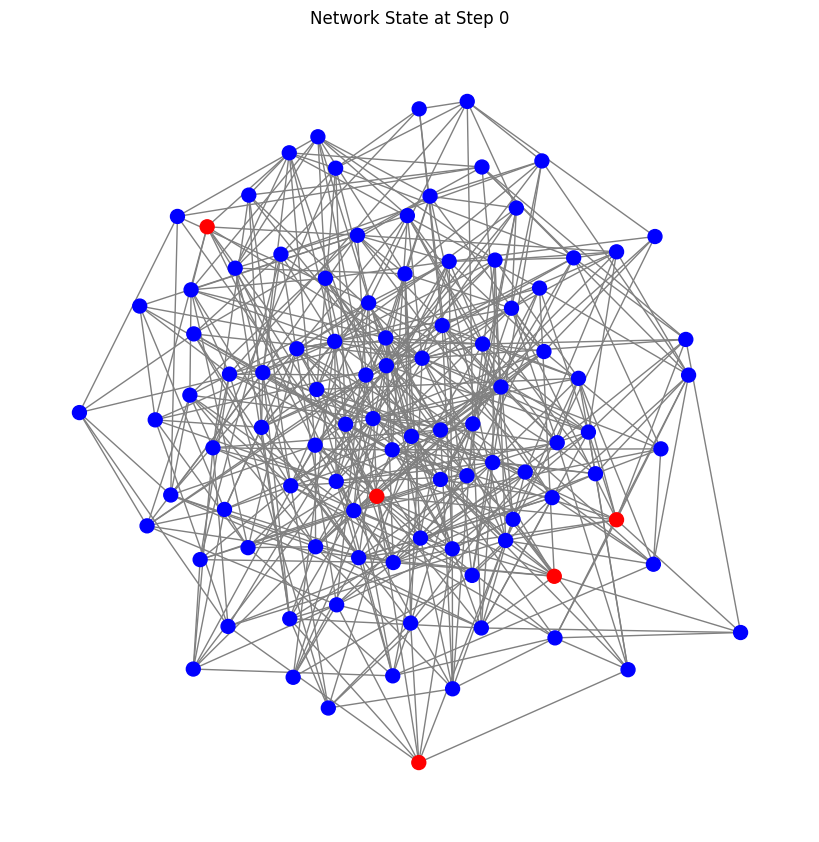

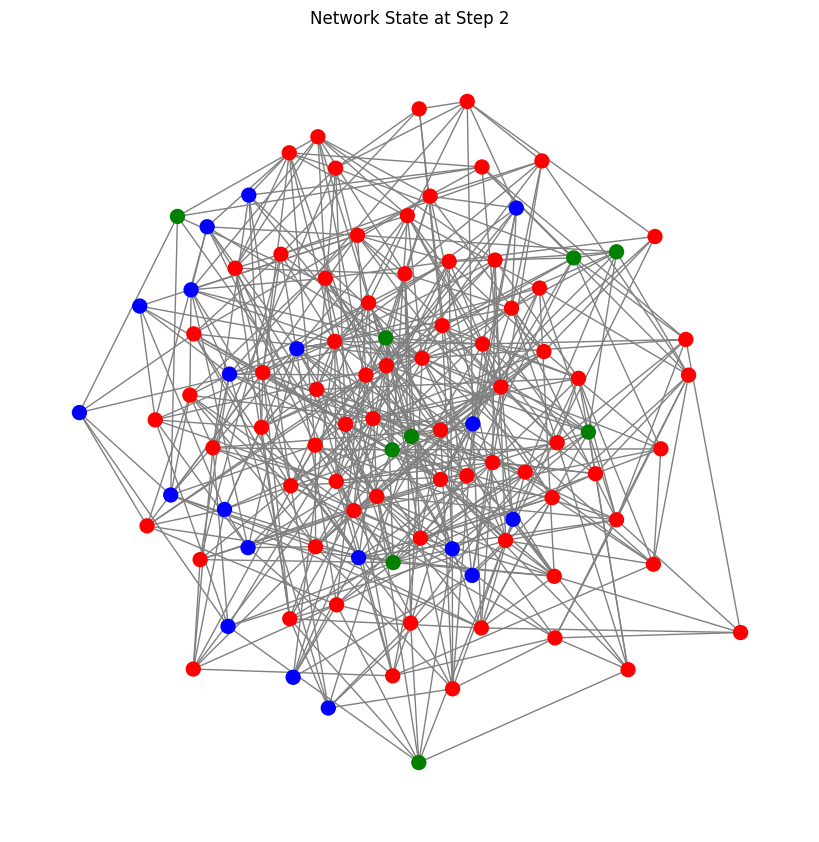

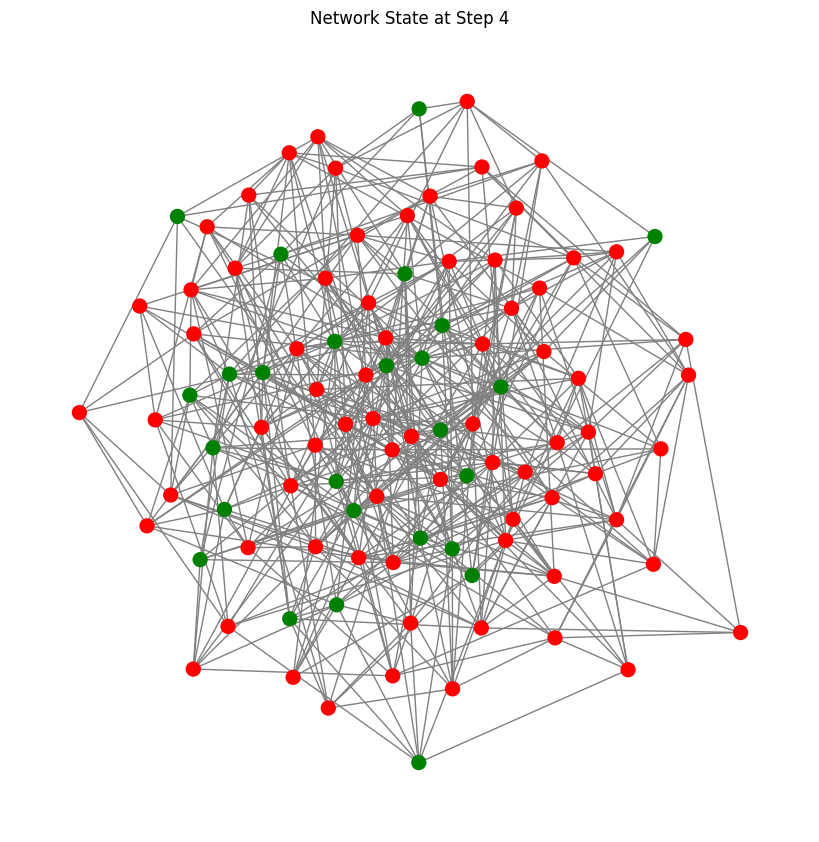

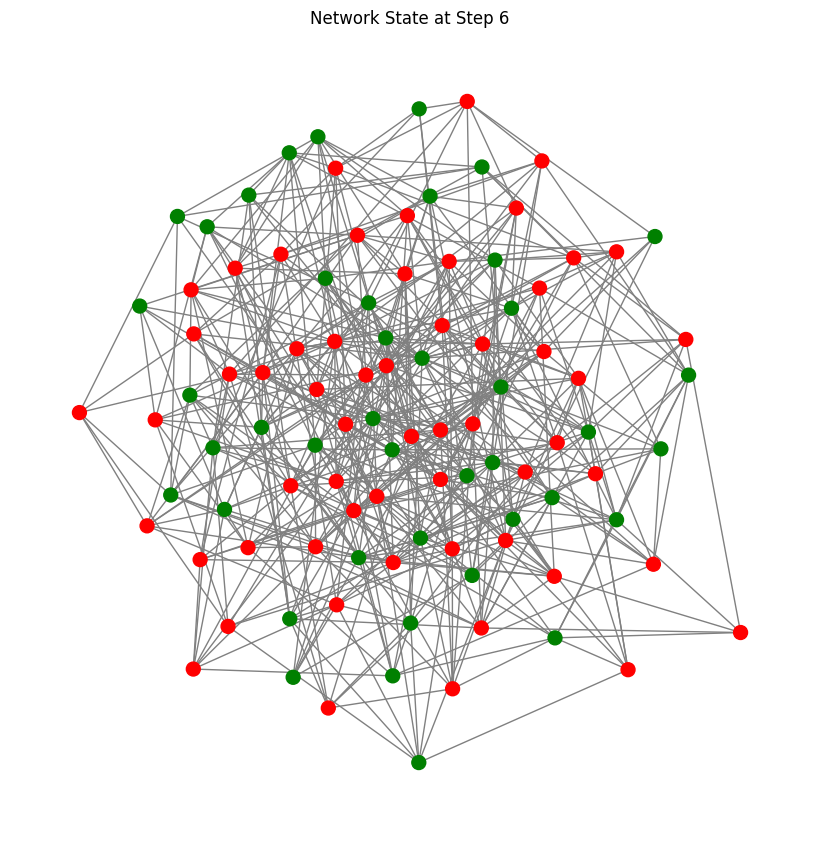

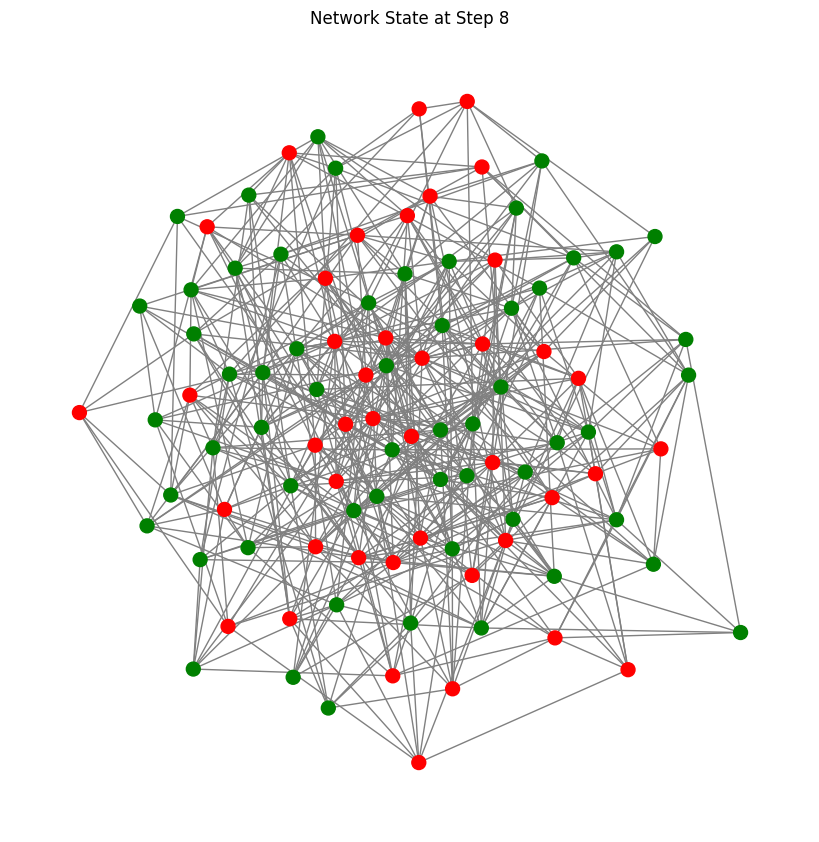

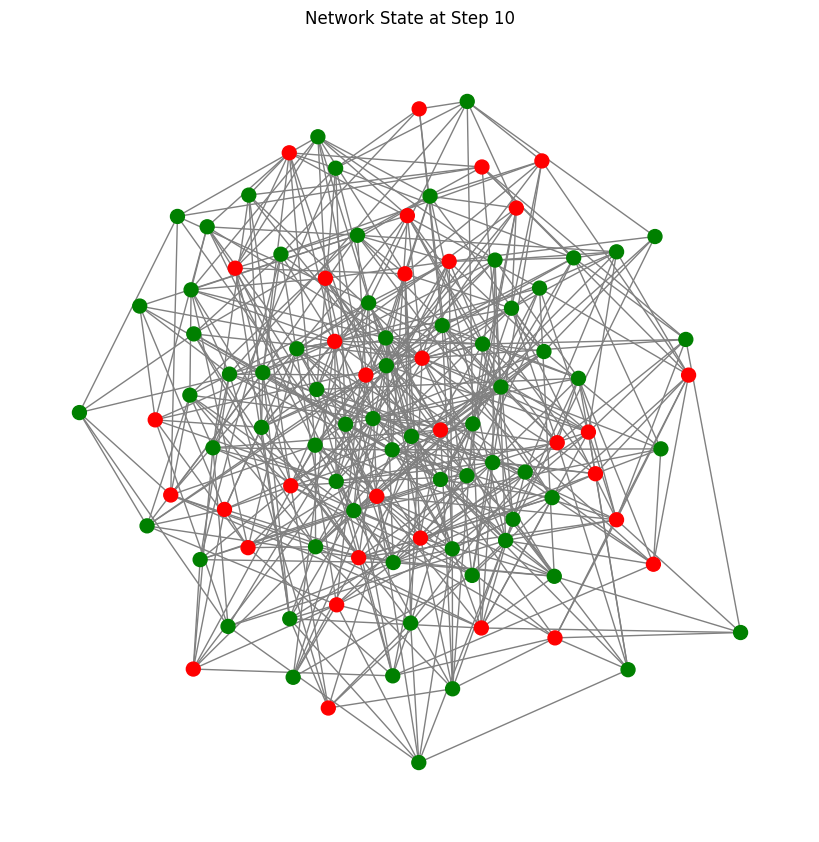

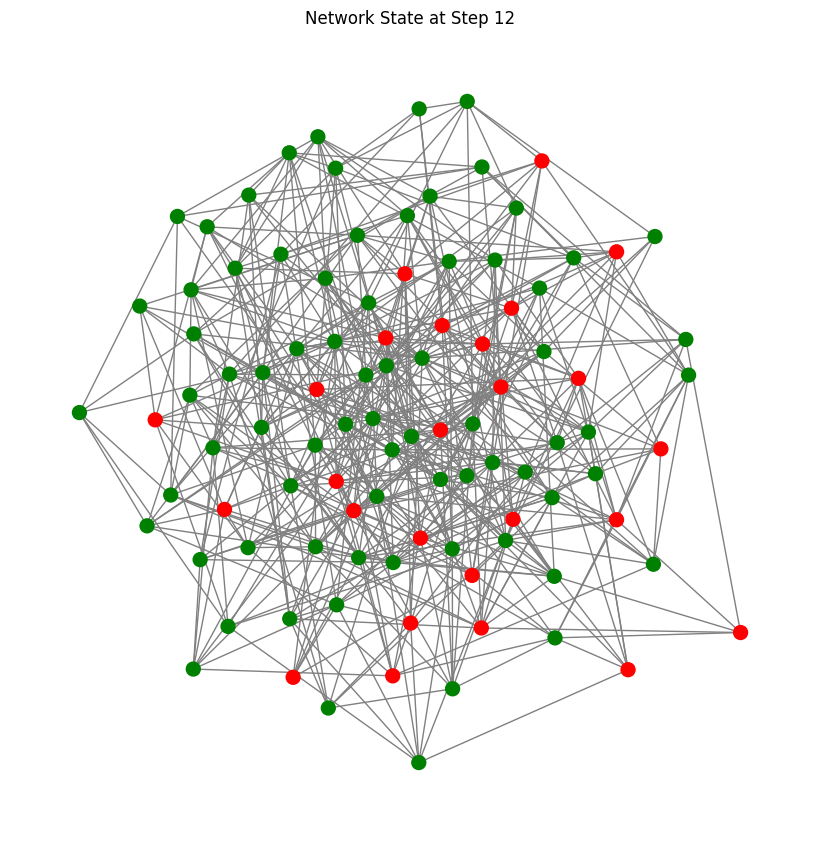

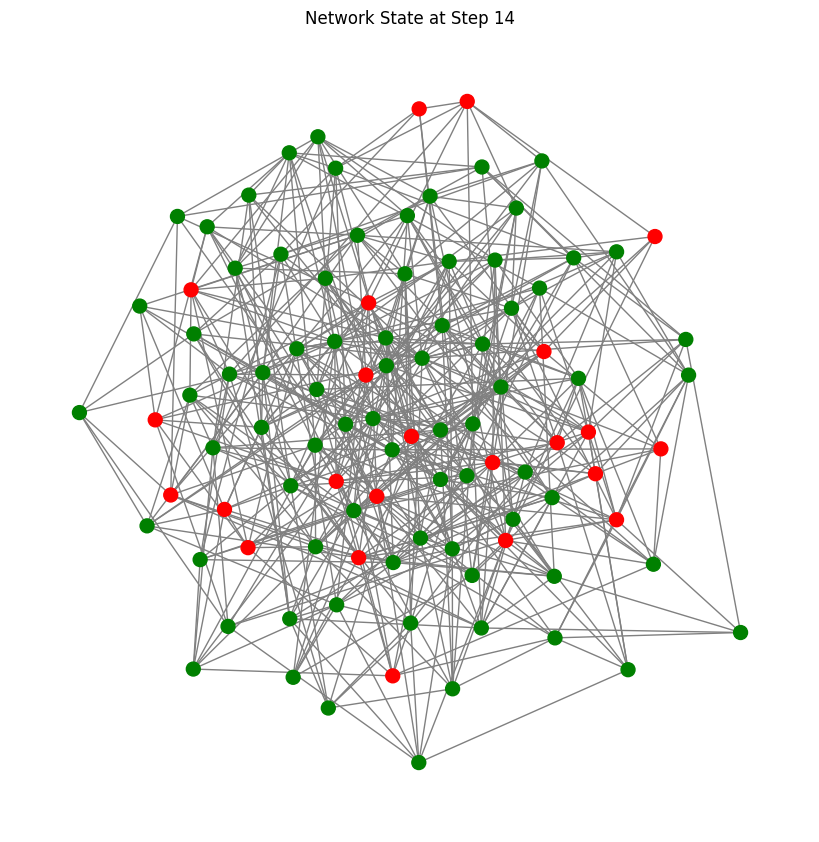


Comparing Epidemic Spread in Both Topologies...


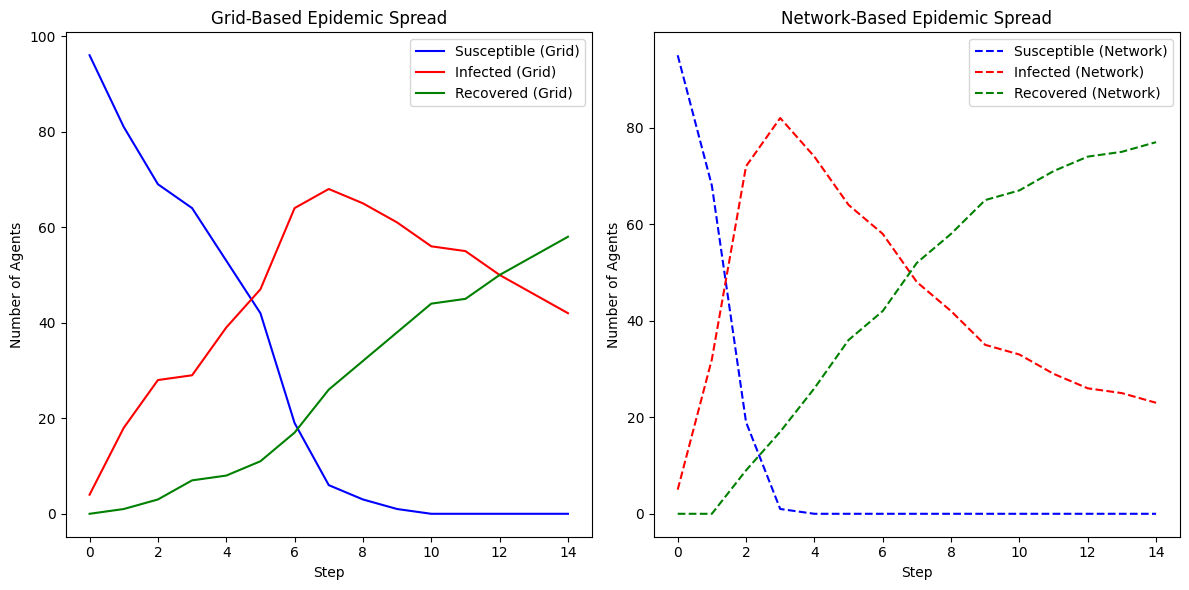

In [4]:
if __name__ == "__main__":
    # Parameters
    num_agents = 100
    grid_width, grid_height = 10, 10
    steps = 15
    infection_prob = 0.3
    recovery_prob = 0.1

    # Grid-Based Topology Simulation
    print("Running Grid-Based Topology Simulation...")
    grid_model = EpidemicModel(
        num_agents=num_agents,
        width=grid_width,
        height=grid_height,
        topology="grid",
        infection_prob=infection_prob,
        recovery_prob=recovery_prob
    )

    print("\nVisualizing Grid-Based Topology:")
    for step in range(steps):
        grid_model.step()
        if step % 2 == 0:  # Visualize grid every 2 steps
            visualize_grid(grid_model, step)

    print("Collecting Data for Grid-Based Topology...")
    grid_data = grid_model.datacollector.get_model_vars_dataframe()

    # Network-Based Topology Simulation
    print("\nRunning Network-Based Topology Simulation...")
    network_model = EpidemicModel(
        num_agents=num_agents,
        width=grid_width,
        height=grid_height,
        topology="network",
        infection_prob=infection_prob,
        recovery_prob=recovery_prob
    )

    print("\nVisualizing Network-Based Topology:")
    for step in range(steps):
        network_model.step()
        if step % 2 == 0:  # Visualize network every 2 steps
            visualize_network(network_model, step)

    print("Collecting Data for Network-Based Topology...")
    network_data = network_model.datacollector.get_model_vars_dataframe()

    # Plot Comparison
    print("\nComparing Epidemic Spread in Both Topologies...")
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(grid_data["Susceptible"], label="Susceptible (Grid)", color="blue")
    plt.plot(grid_data["Infected"], label="Infected (Grid)", color="red")
    plt.plot(grid_data["Recovered"], label="Recovered (Grid)", color="green")
    plt.title("Grid-Based Epidemic Spread")
    plt.xlabel("Step")
    plt.ylabel("Number of Agents")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(network_data["Susceptible"], label="Susceptible (Network)", color="blue", linestyle="--")
    plt.plot(network_data["Infected"], label="Infected (Network)", color="red", linestyle="--")
    plt.plot(network_data["Recovered"], label="Recovered (Network)", color="green", linestyle="--")
    plt.title("Network-Based Epidemic Spread")
    plt.xlabel("Step")
    plt.ylabel("Number of Agents")
    plt.legend()

    plt.tight_layout()
    plt.show()